### OBJECTIVE
- Model data to fit the proposed schema

In [14]:
import ast
import json
import pandas as pd
import boto3
from io import StringIO
import s3_file_operations as s3_ops

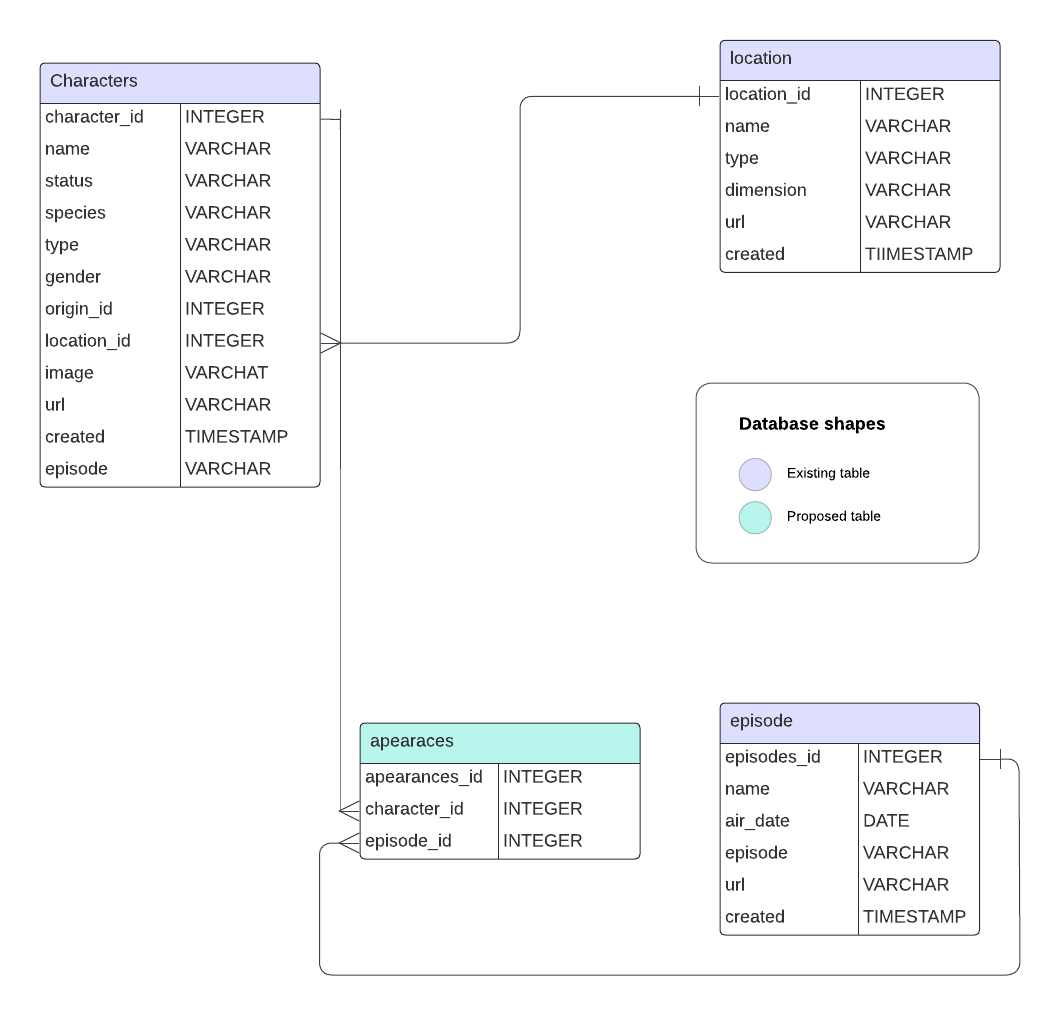

1. Read all the three Datasets Extracted and saved to our Untransformed Bucket in s3

In [23]:
bucket = "de-masterclass-shisia"  # S3 bucket name

# Read data from S3
print("Reading Character data from S3...")
characters_df = s3_ops.read_csv_from_s3(bucket, 'Rick&Morty/Untransformed/Character.csv')
print(f"Characters DataFrame shape: {characters_df.shape}")
print("Reading Episode data from S3...")
episodes_df = s3_ops.read_csv_from_s3(bucket, 'Rick&Morty/Untransformed/Episode.csv')
print(f"Characters DataFrame shape: {episodes_df.shape}")
print("Reading Location data from S3...")
location_df = s3_ops.read_csv_from_s3(bucket, 'Rick&Morty/Untransformed/Location.csv')
print(f"Locations DataFrame shape: {location_df.shape}")

# Check if data is loaded successfully
if characters_df is None or episodes_df is None or location_df is None:
    print("Error in loading data from S3")

print("Data loaded successfully from S3")



Reading Character data from S3...
Characters DataFrame shape: (826, 12)
Reading Episode data from S3...
Characters DataFrame shape: (51, 7)
Reading Location data from S3...
Locations DataFrame shape: (126, 7)
Data loaded successfully from S3


### 1. Characters Dataframe transformation

- Extract origin and location id values from the existing Location and origin columns. These columns consists of json records with key value pairs of locaton name and url respectively. To get the ids of these columns we will need to get the last numeric value from the url after the last back slash (/) of the url string.
- Once this is done we can now drop the original origin and location columns and retain the new ***origin_id*** and ***location_id*** which will now act as foreighn keys to our Location data.
- Rename id to character_id

In [24]:
# Characters DataFrame transformation
extract_id = lambda x: x.split('/')[-1] if x else None

characters_df['origin_id'] = [
    extract_id(ast.literal_eval(record)['url']) if isinstance(record, str) else None
    for record in characters_df['origin']
]

characters_df['location_id'] = [
    extract_id(ast.literal_eval(record)['url']) if isinstance(record, str) else None
    for record in characters_df['location']
]

# Rename the primary key in characters_df to 'character_id'
characters_df = characters_df.rename(columns={'id': 'character_id'})

# Drop unnecessary columns
characters_df = characters_df.drop(columns=['origin', 'location', 'episode'])

# Replace NaN values with None (interpreted as NULL in SQL)
characters_df = characters_df.where(pd.notnull(characters_df), None)
location_df = location_df.where(pd.notnull(location_df), None)

In [25]:
characters_df.head()

,character_id,name,status,species,type,gender,image,url,created,origin_id,location_id
0,1,Rick Sanchez,Alive,Human,None,Male,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/1,2017-11-04T18:48:46.250Z,1,3
1,2,Morty Smith,Alive,Human,None,Male,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/2,2017-11-04T18:50:21.651Z,None,3
2,3,Summer Smith,Alive,Human,None,Female,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/3,2017-11-04T19:09:56.428Z,20,20
3,4,Beth Smith,Alive,Human,None,Female,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/4,2017-11-04T19:22:43.665Z,20,20
4,5,Jerry Smith,Alive,Human,None,Male,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/5,2017-11-04T19:26:56.301Z,20,20


In [26]:
characters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   character_id  826 non-null    int64 
 1   name          826 non-null    object
 2   status        826 non-null    object
 3   species       826 non-null    object
 4   type          425 non-null    object
 5   gender        826 non-null    object
 6   image         826 non-null    object
 7   url           826 non-null    object
 8   created       826 non-null    object
 9   origin_id     526 non-null    object
 10  location_id   805 non-null    object
dtypes: int64(1), object(10)
memory usage: 71.1+ KB


### 2. Appearance Dataframe Creation

- Load the Episodes df that will be our baseline table for the appearance dataframe
- Extract character ids from the character column that consists of a list of urls belonging to all characters that appeared in that particular episode
- Explode the resulting dataframe so that we now have each episode with its respective character as a new row.
- Reset the index of the resulting dataframe so as to generate a new incremental column that will act as the primary key of the new column
- Rename the new columns to resemble the proposed schema,
    1. new_index -> ***appearance_id***
    2. id -> ***episode_id***
    3. character_ids -> ***character_id***
- Once this is done we can now drop all other pre-existing columns that belonged to the episodes dataframe and only retain the three columns generated.

In [27]:
# Appearance DataFrame transformation
appearance_df = episodes_df.copy()

# Function to extract the ID from a URL
character_func = lambda x: [url.split('/')[-1] for url in ast.literal_eval(x)] if isinstance(x, str) else None

# Using list comprehension to extract character_ids
appearance_df['character_ids'] = [
    character_func(record) if record else None
    for record in appearance_df['characters']
]

# Explode the 'character_ids' column to create a row for each character ID
expanded_df = appearance_df.explode('character_ids').reset_index(drop=True).reset_index()

# Rename columns to match the desired output
expanded_df = expanded_df.rename(columns={'index': 'appearance_id', 'id': 'episode_id', 'character_ids': 'character_id'})

# Select only the relevant columns
expanded_df = expanded_df[['appearance_id', 'episode_id', 'character_id']]

# Replace NaN values with None in the expanded DataFrame
expanded_df = expanded_df.where(pd.notnull(expanded_df), None)


In [28]:
expanded_df.head()

,appearance_id,episode_id,character_id
0,0,1,1
1,1,1,2
2,2,1,35
3,3,1,38
4,4,1,62


### 3. Episodes DataFrame transformation

- Drop the original ***character*** column and retain all other pre-existing columns
- Rename id to ***episode_id***

In [29]:
# Episodes DataFrame transformation
episodes_df = episodes_df.drop("characters", axis=1)

# Rename the primary key in episodes_df to 'episode_id'
episodes_df = episodes_df.rename(columns={'id': 'episode_id'})

In [30]:
episodes_df.head()

,episode_id,name,air_date,episode,url,created
0,1,Pilot,"December 2, 2013",S01E01,https://rickandmortyapi.com/api/episode/1,2017-11-10T12:56:33.798Z
1,2,Lawnmower Dog,"December 9, 2013",S01E02,https://rickandmortyapi.com/api/episode/2,2017-11-10T12:56:33.916Z
2,3,Anatomy Park,"December 16, 2013",S01E03,https://rickandmortyapi.com/api/episode/3,2017-11-10T12:56:34.022Z
3,4,M. Night Shaym-Aliens!,"January 13, 2014",S01E04,https://rickandmortyapi.com/api/episode/4,2017-11-10T12:56:34.129Z
4,5,Meeseeks and Destroy,"January 20, 2014",S01E05,https://rickandmortyapi.com/api/episode/5,2017-11-10T12:56:34.236Z


### 4. Locations DataFrame transformation

- Drop the original ***residents*** column and retain all other pre-existing columns
- Rename id to ***location_id***

In [31]:
# Locations DataFrame transformation
location_df = location_df.drop('residents', axis=1)

# Rename the primary key in location_df to 'location_id'
location_df = location_df.rename(columns={'id': 'location_id'})

In [32]:
location_df.head()

,location_id,name,type,dimension,url,created
0,1,Earth (C-137),Planet,Dimension C-137,https://rickandmortyapi.com/api/location/1,2017-11-10T12:42:04.162Z
1,2,Abadango,Cluster,unknown,https://rickandmortyapi.com/api/location/2,2017-11-10T13:06:38.182Z
2,3,Citadel of Ricks,Space station,unknown,https://rickandmortyapi.com/api/location/3,2017-11-10T13:08:13.191Z
3,4,Worldender's lair,Planet,unknown,https://rickandmortyapi.com/api/location/4,2017-11-10T13:08:20.569Z
4,5,Anatomy Park,Microverse,Dimension C-137,https://rickandmortyapi.com/api/location/5,2017-11-10T13:08:46.060Z


Save the final 4 Dataframes to a Transformed Bucket in AWS s3

In [34]:
# Saving our final Dataframes to s3

# Character DataFrame
s3_ops.write_data_to_s3(characters_df, bucket, 'Rick&Morty/Transformed/Character.csv')
# Episodes DataFrame
s3_ops.write_data_to_s3(episodes_df, bucket, 'Rick&Morty/Transformed/Episode.csv')
# Appearance DataFrame
s3_ops.write_data_to_s3(expanded_df, bucket, 'Rick&Morty/Transformed/Appearance.csv')
# Location DataFrame
s3_ops.write_data_to_s3(location_df, bucket, 'Rick&Morty/Transformed/Location.csv')



Data saved to S3 with bucket_name: de-masterclass-shisia and key: Rick&Morty/Transformed/Character.csv
Data saved to S3 with bucket_name: de-masterclass-shisia and key: Rick&Morty/Transformed/Episode.csv
Data saved to S3 with bucket_name: de-masterclass-shisia and key: Rick&Morty/Transformed/Appearance.csv
Data saved to S3 with bucket_name: de-masterclass-shisia and key: Rick&Morty/Transformed/Location.csv


True